# Equilibrium in Fe-N system

In this notebook we implement a sub-lattice model to compute Fe-N equilibrium in the temperature range applicable to continuous nitriding (900-950 K) in ferrite. The primary goal is to compute solubility of nitrogen in BCC-iron. We are also interested in the computation of nitrogen activity in both BCC and FCC iron. In some cases, due to the kinetics of phase transformation in practice, FCC phase can be suppressed and only activity of nitrogen (even above solubility limit) in BCC phase is of practical interest.

In what follows the implementation is done as proposed by *Frisk, K. CALPHAD. Vol. 15, No. 1, p. 79-106, 1991*.

In [1]:
from io import StringIO
from casadi import SX
from casadi import exp
from casadi import log as ln
from casadi import heaviside
from casadi import vertcat
from casadi import dot
from casadi import nlpsol
from casadi import Function
from casadi import linspace
from pandas import DataFrame
from matplotlib import pyplot as plt
import sys

%matplotlib inline

Both BCC and FCC phases are modeled using a sub-lattice model where iron atoms occupy a first lattice and interstital sites are occupied by nitrogen or *vacancies*. A unit formula of $(Fe)_{a}(N,Va)_{c}$ is adopted to describe the compound, with $a=1$ for both structures, and $c=1$ for FCC and $c=3$ for BCC iron. With these elements, the molar Gibbs energy of a phase is given by

$$
G_{m}=y_{N}{}^{\circ}G_{Fe:N}+y_{Va}{}^{\circ}G_{Fe:Va}+cRT(y_{N}\ln{y_{N}}+y_{Va}\ln{y_{Va}})+y_{N}y_{Va}{}^{\circ}L_{Fe:N,Va}+G_{m}^{mag}
$$

where $y_{j}$ denotes the site fractions in interstitial sublattice and besides ideal mixing and entropy terms, a single excess term is added through coefficient $L_{Fe:N,Va}$ and magnetic contribution $G_{m}^{mag}$. All ${}^{\circ}G$ and ${}^{\circ}L$ parameters are expressed in terms of temperature.

In [2]:
def g_sublaticce(x_nn, g_fe_nn, g_fe_va, l_fe_nn_va,
                 c, Tc, beta, p, afm):
    """ Sublattice model for BCC and FCC phases. """
    # Compute site fraction of nitrogen in interstitial sub-lattice.
    y_nn = (x_nn / (1 - x_nn)) * (1 / c)

    # Compute site fraction of vacancies with balance.
    y_va = 1 - y_nn

    # Ideal mixing contribution.
    gmix = y_nn * g_fe_nn + y_va * g_fe_va

    # Entropy terms contribution
    smix = c * R * T * (y_nn * ln(y_nn) + y_va * ln(y_va))

    # Excess term contribution.
    lmix = y_nn * y_va * l_fe_nn_va

    # Magnetic term contribution.
    gmag = gm_magnetic(y_nn, Tc, beta, p, afm)

    # Compose molar Gibbs energy.
    return gmix + smix + lmix + gmag

The magnetic contribution term is given by $G_{m}^{mag}$
$$
G_{m}^{mag}=RT\ln{(1+\beta)f(\tau)}\qquad\text{where}\qquad\tau=\frac{T}{T_{C}}
$$

where depending on Curie's temperature $T_{C}$

$$
f(\tau)=\begin{cases}
\tau < 1   \implies 1 - \dfrac{1}{A}\left[\dfrac{79\tau^{-1}}{140p}+\dfrac{474}{497}\left(\dfrac{1}{p} - 1\right)\left(\dfrac{\tau^3}{6}+\dfrac{\tau^9}{135}+\dfrac{\tau^{15}}{600}\right)\right]\\[20pt]
\tau \ge 1 \implies - \dfrac{1}{A}\left(\dfrac{\tau^{-5}}{10}+\dfrac{\tau^{-15}}{315}+\dfrac{\tau^{-25}}{1500}\right)
\end{cases}
$$

and 

$$
A=\dfrac{518}{1125}+\dfrac{11692}{15975}\left(\dfrac{1}{p} - 1\right)
$$

Parameter $p$ depends on structure and is 0.4 for BCC and 0.28 for FCC. If magnetization and Curie's temperature are negative, they must be divided by $a=-3$ for FCC (for BCC they are positive).

In [3]:
def gm_magnetic(y_nn, Tc, beta, p, afm):
    """ Magnetic contribution to Gibbs energy of phase. """
    # Transform negative values.
    Tc = Tc if Tc > 0 else Tc / afm
    beta = beta if beta > 0 else beta / afm

    # Composition dependency of magnetic term for FCC only.
    if afm <= -3:
        Tc *= (1 - y_nn)
        beta *= (1 - y_nn)

    # Structure parameter.
    A = (518 / 1125) + (11692 / 15975) * (1 / p - 1)

    def f_lo(t):
        """ Function below Curie temperature. """
        a = (79 / 140, 474 / 497, 1/6, 1/135, 1/600)
        b = a[2] * t**3 + a[3] * t**9 + a[4] * t**15 
        return 1 - (a[0] / (p * t) + a[1] * (1 / p - 1) * b) / A

    def f_hi(t):
        """ Function above Curie temperature. """
        a = (1 / 10, 1 / 315, 1 / 1500)
        b = a[0] + a[1] * pow(t, -10) + a[2] * pow(t, -20)
        return -1 * pow(t, -5) * b / A

    # Relative temperature.
    tau = T / Tc

    # Select temperature range with HEAVY-SIDE function.
    h = heaviside(tau - 1)
    f = (1 - h) * f_lo(tau) + h * f_hi(tau)

    # Assembly model.
    return R * T * ln(1 + beta) * f

Model coefficients are expressed in terms of temperature as polynomials as

$$
G=a_0 + a_1 T + a_2 T\ln{T} + a_3 T^2 + a_4 T^3 + a_5 T^{-1}
$$

Other terms might be added depending on phase and its reference state.

In [4]:
def gparams(a):
    """ Parameter representation with 6 coefficients. """
    b = a[1] + a[2] * ln(T) + a[3] * T + a[4] * T**2
    return a[0] + T * b + a[5] / T

To build the optimization problem we start by defining the required constants and symbols.

In [5]:
# Ideal gas constant [J/(mol.K)].
R = 8.31446261815324

# Atomic masses.
mm_fe = 5.5847E+01
mm_nn = 1.4007E+01

# Symbol for system temperature.
T = SX.sym('T')

# Symbol for total molar fraction of nitrogen.
x0 = SX.sym('x0')

# Symbols for unknowns: phases fractions and compositions.
phi = SX.sym('phi', 2)
x_nn = SX.sym('x_nn', 2)

# Aliases for phases fractions.
phi_alpha = phi[0]
phi_gamma = phi[1]

# Aliases for molar fraction in phases.
x_nn_alpha = x_nn[0]
x_nn_gamma = x_nn[1]

Next we provide $G-H_{SER}$ for the pure elements, with reference state for iron being BCC and for nitrogen $\frac{1}{2}N_{2}(g)$.

In [6]:
# SER : BCC_A2 : CHECKED
a_ghser_fe = (1224.83, 124.134, -23.5143, -4.39752e-03, -5.89269e-08, 77358.5)
ghser_fe = gparams(a_ghser_fe)

# SET : 1/2 N2 : CHECKED
a_ghser_nn = (-3750.675, -9.45425, -12.7819, -1.76686e-04, 2.681e-09, -32374)
ghser_nn = gparams(a_ghser_nn)

The next cell provide all parameters for BCC description.

In [7]:
# G(BCC_A2,FE:VA;0) : CHECKED
g_fe_va_alpha = ghser_fe

# G(BCC_A2,FE:N;0) : CHECKED
a_g_fe_nn_alpha = (93562, 165.07, 0, 0, 0, 0)
g_fe_nn_alpha = gparams(a_g_fe_nn_alpha) + ghser_fe + 3 * ghser_nn

# Magnetic model parameters : CHECKED.
Tc_alpha, beta_alpha, p_alpha, afm_alpha = 1043, 2.22, 0.40, -1

# BCC_A2 R-K parameter : CHECKED.
l_fe_nn_va_alpha = 0.0

# Stoichiometric parameter : CHECKED.
c_alpha = 3

The next cell provide all parameters for FCC description.

In [8]:
# G(FCC_A1,FE:VA;0) : CHECKED.
a_g_fe_va_gamma = (-1462.4, 8.282, -1.15, 6.4e-04, 0.0, 0.0)
g_fe_va_gamma = gparams(a_g_fe_va_gamma) + ghser_fe

# G(FCC_A1,FE:N;0) : CHECKED.
a_g_fe_nn_gamma = (-37460, 375.42, -37.6, 0, 0, 0)
g_fe_nn_gamma = gparams(a_g_fe_nn_gamma) + ghser_fe + ghser_nn

# Magnetic model parameters: CHECKED.
Tc_gamma, beta_gamma, p_gamma, afm_gamma = -201, -2.1, 0.28, -3

# FCC_A1 R-K parameter : CHECKED.
l_fe_nn_va_gamma = -26150.0

# Stoichiometric parameter : CHECKED.
c_gamma = 1

With all these parameters in hand we compute molar Gibbs energy of each phase.

In [9]:
# BCC_A2 molar Gibbs energy.
Gm_alpha = g_sublaticce(x_nn_alpha, g_fe_nn_alpha, g_fe_va_alpha,
                        l_fe_nn_va_alpha, c_alpha, Tc_alpha,
                        beta_alpha, p_alpha, afm_alpha)

# FCC_A1 molar Gibbs energy.
Gm_gamma = g_sublaticce(x_nn_gamma, g_fe_nn_gamma, g_fe_va_gamma,
                        l_fe_nn_va_gamma, c_gamma, Tc_gamma,
                        beta_gamma, p_gamma, afm_gamma)

Prepare equilibrium conditions with composition converted to mole fraction.

$$
x = \dfrac{w\bar{M}}{M_{N}}\qquad\text{where}\qquad{}\bar{M}=\left(\sum_{k}\dfrac{w_k}{M_k}\right)^{-1}
$$

In [10]:
def mass_to_mole_fraction(w):
    """ Convert mass fraction of nitrogen into mole fraction.  """
    return w / (mm_nn * (w / mm_nn + (1 - w) / mm_fe))

def mole_to_mass_fraction(x):
    """ Convert mole fraction of nitrogen into mass fraction.  """
    return x * mm_nn / (x * mm_nn + (1 - x) * mm_fe)

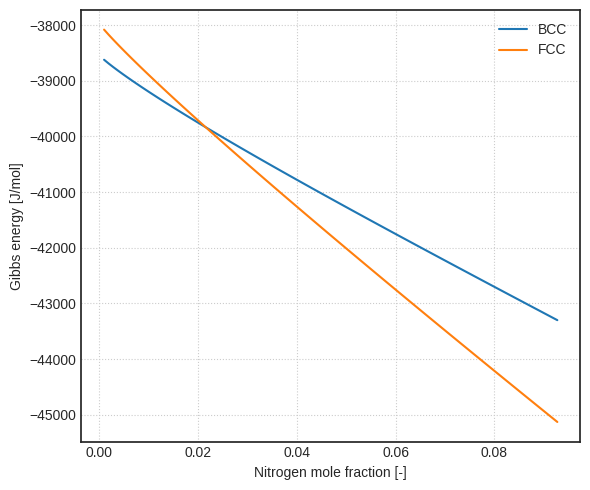

In [11]:
T_num = 943.0
x_nn_rng = linspace(0.00, mass_to_mole_fraction(0.025), 100)
Gm_alpha_f = Function('Gm_alpha', [T, x_nn_alpha], [Gm_alpha])
Gm_gamma_f = Function('Gm_gamma', [T, x_nn_gamma], [Gm_gamma])

plt.close('all')
plt.style.use('seaborn-white')
plt.figure(figsize=(6, 5), dpi=100)
plt.plot(x_nn_rng, Gm_alpha_f(T_num, x_nn_rng), label='BCC')
plt.plot(x_nn_rng, Gm_gamma_f(T_num, x_nn_rng), label='FCC')
plt.xlabel('Nitrogen mole fraction [-]')
plt.ylabel('Gibbs energy [J/mol]')
plt.grid(linestyle=':')
plt.legend(loc='best')
plt.tight_layout()


These elements allow to build the following optimization problem, where $f$ is the cost function

$$
\begin{cases}
f = \phi_{BCC}G_{m}^{BCC} + \phi_{FCC}G_{m}^{FCC} \\[12pt]
0 = \phi_{BCC}x_{N}^{BCC} + \phi_{FCC}x_{N}^{FCC} - x_{N}^{sys} \\[12pt]
0 = \phi_{BCC} + \phi_{FCC} - 1
\end{cases}
$$

In [12]:
# Assembly symbolicy cost function.
f = phi_alpha * Gm_alpha + phi_gamma * Gm_gamma

# Create total nitrogen content constraint.
g0 = phi_alpha * x_nn_alpha + phi_gamma * x_nn_gamma - x0

# Constrain phase fractions.
g1 = phi_alpha + phi_gamma - 1

# Create symbolic vectors.
x = vertcat(phi, x_nn)
g = vertcat(g0, g1)
p = vertcat(T, x0)

# Construct optimization problem.
opts = {'ipopt': {'print_level': 1}}
nlpt = {'x': x, 'f': f, 'g': g, 'p': p}
solver = nlpsol('solver', 'ipopt', nlpt, opts)

Because Ipopt output can be verbose we capture it with the following class.

In [13]:
class Capturing(list):
    """ Helper to capture excessive solver output.

    In some cases, specially when running from a notebook, it might
    be desirable to capture solver (here Ipopt specifically) output
    to later check, thus avoiding a overly long notebook.  For this
    end this context manager is to be used and redirect to a list.
    """
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        sys.stderr = sys.stdout
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout

The computation of nitrogen activity is done as proposed by *Kouba, R et al. CALPHAD, Vol. 71, 2020.*

In [14]:
def nitrogen_activity(kn, dg, T):
    """ Nitrogen activity in material. """
    return kn * exp(-dg / (R * T))

Sample Thermo-Calc and OpenCalphad macros are provided in this directory to validate results of calculations. Consider changing temperature and composition for the different cases.

In [15]:
def ce(T0_num, w0_num, kn=0.05):
    """ Compute equilibrium at given point. """
    x0_num = mass_to_mole_fraction(w0_num)

    # A good initial guess is expected for now.
    guess = [1, 1, x0_num, x0_num]

    with Capturing() as output:
        sol = solver(x0=guess, p=[T0_num, x0_num],
                     lbx=0, ubx=1, lbg=-1.0e-08, ubg=1.0e-08)

    sol['ac'] = nitrogen_activity(kn, sol['f'], T0_num)
    sol['x0'] = x0_num
    sol['w0'] = w0_num

    return sol

In [16]:
ce(T0_num=943, w0_num=0.0001)

{'f': DM(-38578.7),
 'g': DM([1.99669e-08, 1.99286e-08]),
 'lam_g': DM([82382.2, 38125]),
 'lam_p': DM([64.0186, 82382.2]),
 'lam_x': DM([420.842, -103.221, -0.00683478, -8.58466e-05]),
 'x': DM([1, 1.64051e-08, 0.000398608, 0.0307421]),
 'ac': DM(6.853),
 'x0': 0.0003985887274051929,
 'w0': 0.0001}

In [17]:
ce(T0_num=943, w0_num=0.0010)

{'f': DM(-38838.3),
 'g': DM([1.99678e-08, 1.99418e-08]),
 'lam_g': DM([70941.9, 38556.3]),
 'lam_p': DM([64.412, 70941.9]),
 'lam_x': DM([0.000110002, -0.000110002, -0.00130096, -1.79825e-05]),
 'x': DM([0.979672, 0.020328, 0.00175216, 0.111112]),
 'ac': DM(7.0837),
 'x0': 0.003975203646706774,
 'w0': 0.001}

Next we perform a stepping for confrontation with Thermo-Calc calculations over the full composition range.

In [18]:
w0_num = linspace(0.0, 0.035, 200).full().ravel()
data = [ce(T0_num=943, w0_num=w) for w in w0_num]

In [19]:
def get_item(results):
    """ Retrieve results for assembly of table. """
    x = results['x'].full().ravel()
    f = results['f'].full().ravel()[0]
    ac = results['ac'].full().ravel()[0]

    return {
        'X(N)': results['x0'],
        'W(N)': results['w0'],
        'Total Gibbs energy': f,
        'NP(BCC_A2)': x[0],
        'NP(FCC_A1)': x[1],
        'X(BCC_A2,N)': x[2],
        'X(FCC_A1,N)': x[3],
        'W(BCC_A2,N)': mole_to_mass_fraction(x[2]),
        'W(FCC_A1,N)': mole_to_mass_fraction(x[3]),
        'ACR(N)': ac
    }

df = DataFrame(list(map(get_item, data)))
df

,X(N),W(N),Total Gibbs energy,NP(BCC_A2),NP(FCC_A1),"X(BCC_A2,N)","X(FCC_A1,N)","W(BCC_A2,N)","W(FCC_A1,N)",ACR(N)
0,0.000000,0.000000,-38542.779994,1.000000e+00,1.000436e-08,1.999988e-08,0.000011,5.016174e-09,0.000003,6.821648
1,0.000701,0.000176,-38602.906510,1.000000e+00,1.789437e-08,7.008958e-04,0.045774,1.758842e-04,0.011888,6.874163
2,0.001401,0.000352,-38655.427941,1.000000e+00,3.404967e-08,1.401035e-03,0.088372,3.517631e-04,0.023736,6.920365
3,0.002100,0.000528,-38705.334319,9.968152e-01,3.184793e-03,1.752156e-03,0.111112,4.400364e-04,0.030398,6.964555
4,0.002799,0.000704,-38754.899506,9.904265e-01,9.573525e-03,1.752159e-03,0.111112,4.400371e-04,0.030398,7.008722
...,...,...,...,...,...,...,...,...,...,...
195,0.124036,0.034296,-47352.455095,5.340272e-08,1.000000e+00,4.723812e-03,0.124036,1.188988e-03,0.034296,20.982884
196,0.124612,0.034472,-47393.076981,5.105415e-08,1.000000e+00,4.835111e-03,0.124612,1.217104e-03,0.034472,21.091879
197,0.125189,0.034648,-47433.647728,4.891631e-08,1.000000e+00,4.944785e-03,0.125189,1.244814e-03,0.034648,21.201301
198,0.125764,0.034824,-47474.167430,4.696326e-08,1.000000e+00,5.052849e-03,0.125764,1.272122e-03,0.034824,21.311152


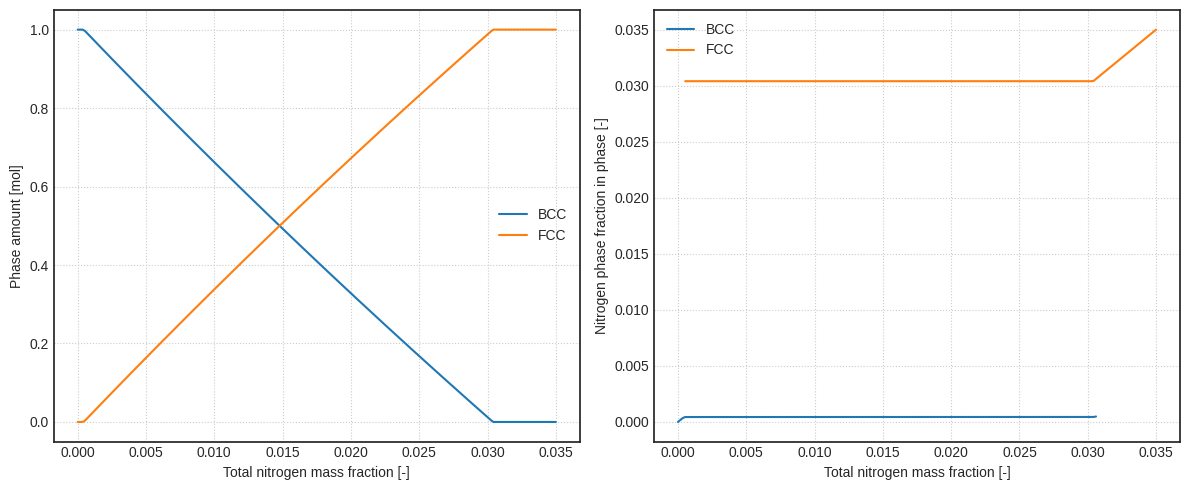

In [20]:
bcc_stable = df.loc[df['NP(BCC_A2)'] > 1.0e-06]
fcc_stable = df.loc[df['NP(FCC_A1)'] > 1.0e-06]

plt.close('all')
plt.style.use('seaborn-white')
plt.figure(figsize=(12, 5), dpi=100)
plt.subplot(121)
plt.plot(df['W(N)'], df['NP(BCC_A2)'], label='BCC')
plt.plot(df['W(N)'], df['NP(FCC_A1)'], label='FCC')
plt.xlabel('Total nitrogen mass fraction [-]')
plt.ylabel('Phase amount [mol]')
plt.grid(linestyle=':')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(bcc_stable['W(N)'], bcc_stable['W(BCC_A2,N)'], label='BCC')
plt.plot(fcc_stable['W(N)'], fcc_stable['W(FCC_A1,N)'], label='FCC')
plt.xlabel('Total nitrogen mass fraction [-]')
plt.ylabel('Nitrogen phase fraction in phase [-]')
plt.grid(linestyle=':')
plt.legend(loc='best')
plt.tight_layout()